In [31]:
import numpy as np
import math
import pandas as pd
import os
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import jpholiday
from sklearn.preprocessing import LabelEncoder
from ydata_profiling import ProfileReport

pd.options.display.max_rows = 1000
pd.options.display.max_columns = 300

%matplotlib inline

In [16]:
train = pd.read_csv('./given_files/train.csv', encoding='utf-8')
search_specified = pd.read_csv('./given_files/search_specified.csv', encoding='utf-8')
search_unspecified = pd.read_csv('./given_files/search_unspecified.csv', encoding='utf-8')
road = pd.read_csv('./given_files/road_local.csv', encoding='utf-8')

In [17]:
# day_of_week, day_of_year, holiday, tomorrow_holiday, yesterday_holidayを追加
def is_holiday(date):
    
    return (date.weekday() >= 5) or jpholiday.is_holiday(date)


def set_flags(df):
    
    df['tomorrow'] = df['date'] + pd.to_timedelta(1, 'd')
    df['day_of_week'] = df['date'].dt.weekday
    
    holidays = df['date'].apply(jpholiday.is_holiday)

    df['holiday'] = ((df['day_of_week'] >= 5) | holidays).astype(int)
    df['tomorrow_holiday'] = ((df['tomorrow'].dt.weekday >= 5) | holidays.shift(-1)).astype(int)
    
    # 連休何日目か(n_of_holidays)を追加
    mask = df['holiday'] != df['holiday'].shift(1).fillna(0)
    df['n_of_holidays'] = df.groupby(mask.cumsum()).cumcount() + 1
    df.loc[df['holiday'] == 0, 'n_of_holidays'] = 0
    
    ## 連休の始まりを特定
    #df['holiday_start'] = ((df['holiday'] == 1) & (df['holiday'].shift(1) == 0)).astype(int)
    ## 連休の終わりを特定
    #df['holiday_end'] = ((df['holiday'] == 1) & (df['holiday'].shift(-1) == 0)).astype(int)
    ## 連休の中間を特定
    #df['holiday_mid'] = (df['holiday'] & ~(df['holiday_start'] | df['holiday_end'])).astype(int)
    #
    #df.loc[df['holiday_start'] == 1, 'holiday_sme'] = 1
    #df.loc[df['holiday_mid'] == 1, 'holiday_sme'] = 2
    #df.loc[df['holiday_end'] == 1, 'holiday_sme'] = 3
    #df['holiday_sme'].fillna(0, inplace=True)
    
    df = df.drop(['tomorrow'], axis=1)
    
    return df

search_unspecified['date'] = pd.to_datetime(search_unspecified['date'])

search_unspecified = set_flags(search_unspecified)

search_unspecified['day_of_year'] = search_unspecified['date'].dt.dayofyear

def expand_datetime(df):
    if 'date' in df.columns:
        df['year'] = df['date'].dt.year
        df['month'] = df['date'].dt.month
        df['day'] = df['date'].dt.day
    if 'datetime' in df.columns:
        df['year'] = df['datetime'].dt.year
        df['month'] = df['datetime'].dt.month
        df['day'] = df['datetime'].dt.day
        df['hour'] = df['datetime'].dt.hour
    return df

train['datetime'] = pd.to_datetime(train['datetime'])
train['date'] = train['datetime'].dt.date
train['date'] = pd.to_datetime(train['date'])
search_specified['datetime'] = pd.to_datetime(search_specified['datetime'])
search_unspecified['date'] = pd.to_datetime(search_unspecified['date'])
search_specified['datetime'] -= pd.to_timedelta(1, 'd')
search_unspecified['date'] -= pd.to_timedelta(1, 'd')

train = expand_datetime(train)

train_merged = train.merge(search_specified, on=['datetime', 'start_code', 'end_code'], how='left')

train_merged = train_merged.merge(search_unspecified, on=['date', 'start_code', 'end_code'], how='left')

train_merged = train_merged.merge(road, on=['start_code', 'end_code'], how='left')

In [36]:
train_merged['section'] = train_merged['start_code'].astype(str) + '_' + train_merged['KP'].astype(str) + '_' + train_merged['end_code'].astype(str)

label_encoder = LabelEncoder()
train_merged['section'] = label_encoder.fit_transform(train_merged['section'])

train_merged['direction'] = train_merged['direction'].replace({'上り': 1, '下り': 0})

In [48]:
df = train_merged[(train_merged['date'] == '2021-04-08') & (train_merged['hour'] == 12) & (train_merged['direction'] == 0)]

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 130 entries, 12 to 3795324
Data columns (total 36 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   datetime            130 non-null    datetime64[ns]
 1   start_code          130 non-null    int64         
 2   end_code            130 non-null    int64         
 3   KP                  130 non-null    float64       
 4   OCC                 122 non-null    float64       
 5   allCars             130 non-null    int64         
 6   speed               130 non-null    float64       
 7   is_congestion       130 non-null    int64         
 8   date                130 non-null    datetime64[ns]
 9   year                130 non-null    int64         
 10  month               130 non-null    int64         
 11  day                 130 non-null    int64         
 12  hour                130 non-null    int64         
 13  search_specified    130 non-null    float64  

In [60]:
train_merged_profile = ProfileReport(df, title="Profiling Report:df", minimal=True)
train_merged_profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

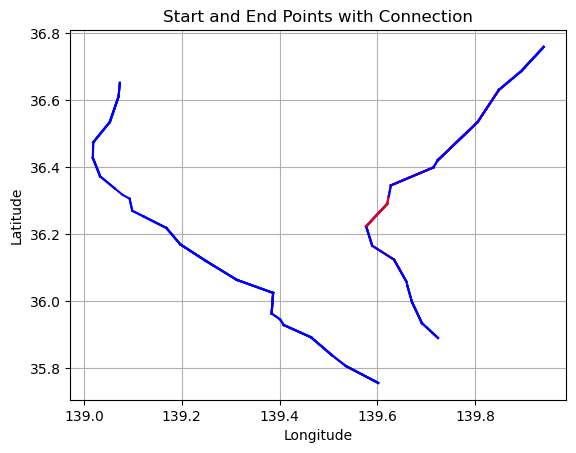

In [61]:
for index,row in df.iterrows():
    
    start_lng = row['start_lng']
    end_lng = row['end_lng']
    start_lat = row['start_lat']
    end_lat = row['end_lat']
    speed = row['speed']

    if speed >= 100:
        line = 'r-'
    elif speed < 100 and speed >= 80:
        line = 'b-'
    else:
        line = 'k-'

    plt.plot(start_lng, start_lat, 'r', label='Start') 
    plt.plot(end_lng, end_lat, 'b', label='End') 
    plt.plot([start_lng, end_lng], [start_lat, end_lat], line)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Start and End Points with Connection')
#plt.legend()
plt.grid(True)
plt.show()